In [1]:
import numpy as np
import scipy.stats
import sherpa.astro.ui as ui
from sherpa.astro import xspec
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
import matplotlib.pyplot as plt

failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'


In [2]:
datadir = "./"
ui.load_data(id="p1", filename=datadir+"fake_acis.pha")
d = ui.get_data("p1")

arf = d.get_arf() # get out an ARF object
rmf = d.get_rmf() # get out an RMF object

energ_lo = arf.energ_lo
energ_hi = arf.energ_hi

statistical errors were found in file './fake_acis.pha' 
but not used; to use them, re-read with use_errors=True
read ARF file arfs/aciss_hetg0_cy19.arf
read RMF file rmfs/aciss_hetg0_cy19.rmf


In [3]:
lineE = 6.315 # input line energy, keV (assume known?)

def simulate_pileup_spec(pars, energ_lo, energ_hi, arf, rmf, frametime=3.2, exposure=1.0, tstart=0.0, basespec=False):
    
    # set up the XSPEC model and parameters
    pl = xspec.XSpowerlaw()
    pl.norm = np.exp(pars[0])
    pl.PhoIndex = pars[1]
    
    g = xspec.XSgaussian()
    g.norm = np.exp(pars[2])
    g.Sigma = pars[3]
    g.LineE = lineE 

    # calculate the base model intensities
    base_model = pl(energ_lo, energ_hi) + g(energ_lo, energ_hi)

    # apply ARF adn RMF
    base_arf = arf.apply_arf(base_model)*exposure
    base_spec = rmf.apply_rmf(base_arf)

    # get the number of photons from a Poisson distribution
    nphot = np.random.poisson(np.sum(base_spec))

    # get the end time for the exposure
    tend = tstart + exposure

    # get the photon arrival times for a constant light curve
    phot_times = np.random.uniform(tstart, tend, size=nphot)
    
    # sort the photon arrival times
    phot_times = np.sort(phot_times)
    
    # normalize the probability density function for the spectrum
    spec_pdf = base_spec/np.sum(base_spec)
    
    # get photon energies for each photon arrival time
    phot_energies = np.random.choice(energ_lo, size=nphot, replace=True, p=spec_pdf)

    # calculate the read-out intervals, starting with the start time of the exposure
    intervals = np.arange(tstart, tend+frametime, frametime)
    
    # bin the energies according to the intervals, sum up the photon energies in eaach frame
    summed_erg, bins, bin_idx = scipy.stats.binned_statistic(phot_times, phot_energies, 
                                                             bins=intervals, statistic="sum")
    
    # only include bins where the energy is greater than zero
    # and within the bounds of the spectrum
    summed_erg = summed_erg[(summed_erg > 0) & (summed_erg < np.max(energ_hi))]
    
    # get the energy intervals in a form that I can stick them into a 
    # histogram frunction
    energ_intervals = np.hstack([energ_lo, energ_hi[-1]])

    # calculate the piled-up spectrum in counts/bin
    spec_pileup, spec_bins = np.histogram(summed_erg, bins=energ_intervals)
    
    if basespec:
        spec_nopileup, _ = np.histogram(phot_energies, bins=energ_intervals)
        return spec_bins, spec_pileup, spec_nopileup
    else:
        return spec_bins, spec_pileup

In [4]:
energ_intervals = np.hstack([energ_lo, energ_hi[-1]])
# summed energy of each combination of photon energies
energ_k = (energ_lo[:, None] + energ_lo[None, :]).flatten()
idx_energ_k = np.digitize(energ_k, energ_intervals) - 1
msk_energ_k = (energ_k >= energ_intervals[0]) & (energ_k < energ_intervals[-1])
idx_energ_k = idx_energ_k[msk_energ_k]

In [5]:
from scipy.stats import poisson
from scipy.special import loggamma

def pileup_spec_like(pars, energ_lo, energ_hi, arf, rmf, frametime=3.2, exposure=1.0, tstart=0.0):
    
    # set up the XSPEC model and parameters
    pl = xspec.XSpowerlaw()
    pl.norm = np.exp(pars[0])
    pl.PhoIndex = pars[1]
    
    g = xspec.XSgaussian()
    g.norm = np.exp(pars[2])
    g.Sigma = pars[3]
    g.LineE = lineE 

    # calculate the base model intensities
    base_model = pl(energ_lo, energ_hi) + g(energ_lo, energ_hi)

    # apply ARF adn RMF
    base_arf = arf.apply_arf(base_model)*frametime # was *exposure
    base_spec = rmf.apply_rmf(base_arf)

    mu = np.sum(base_spec) # expected number of photons per frame
    prob_1 = base_spec.copy() / mu # distribution of photon energies
    
    # build probability distribution for piled up photon energy this frame
    # will not add to one, as there is poisson.pmf(0, mu) chance of zero photons
    pile_spec = poisson.pmf(1, mu) * prob_1.copy() # chance of one photon x one photon distribution
    
    # distribution of energies of k piled up photons, starting with k = 1
    conv_spec = prob_1.copy()
        
    # add contributions from piled up photons, starting with pairs
    k = 2
    while k < mu or poisson.pmf(k, mu) > 0.001:
        # probability of each combination of photon energies = distribution for k-1 * distribution for 1
        prob_k = (conv_spec[:, None] * prob_1[None, :]).flatten()
        
        conv_spec = np.bincount(idx_energ_k, prob_k[msk_energ_k])
        
        # summed energy of each combination of photon energies
        #energ_k = (energ_lo[:, None] + energ_lo[None, :]).flatten() # TODO: these will always fall in same energy bins
        # rebin to spectral bins
        #conv_spec, _, _ = scipy.stats.binned_statistic(energ_k, prob_k, bins=energ_intervals, statistic="sum")
        
        # add to piled up distribution
        pile_spec += poisson.pmf(k, mu) * conv_spec
        k += 1
        
    # check if observed photons have impossible energies
    if np.sum(sim_spec[pile_spec == 0]) > 0:
        print('impossible photons', np.sum(sim_spec[pile_spec == 0]), pars, mu)
        return float('-inf')
    else:
        pile_spec[pile_spec == 0] = 1e-9 # makes k * log(p) = 0 when k = 0
    
    prob_0 = 1 - np.sum(pile_spec) # chance of no photon / photon out of range
    frame_0 = (exposure // frametime) - np.sum(sim_spec) # number of empty frames
    
    assert(frame_0 >= 0)
    
    return np.sum(sim_spec*np.log(pile_spec)) + frame_0*np.log(prob_0)

class PiledLogPosterior(object):
    '''def __init__(self, spec, pl, g):
        self.spec = spec
        self.pl = pl
        self.g = g
        
        self.arf = self.spec.get_arf()
        self.rmf = self.spec.get_rmf()
        
        # calculate log-counts here for the likelihood
        # makes things slightly faster
        self.sum_log_counts = gammaln(self.spec.counts+1)    
        
        # set the log-likelihood:
        self.loglikelihood = PoissonLogLikelihood(spec, pl, g)
        
        return'''

    def logprior(self, pars):
        # log-prior for power law model ONLY.
        log_norm = pars[0]
        phoindex = pars[1]
        log_norml = pars[2]
        sigma = pars[3]
        
        # above -3, basically all photons will be piled out of 
        # the observable energy range
        p_lognorm = scipy.stats.uniform(-10, 7).logpdf(log_norm)
        p_phoindex = scipy.stats.uniform(-2, 5).logpdf(phoindex)
        p_lognorml = scipy.stats.uniform(-10, 7).logpdf(log_norml)
        p_sigma = scipy.stats.uniform(0.0, 0.1).logpdf(sigma)
        
        return p_lognorm + p_phoindex + p_lognorml + p_sigma
    
    def loglikelihood(self, pars):
        return pileup_spec_like(pars, energ_lo, energ_hi, arf, rmf, exposure=1e4)
    
    def logposterior(self, pars):
        p = self.logprior(pars)
        if p > float('-inf'): # only call likelihood if parameters are sensible
            p += self.loglikelihood(pars) 
        return p
    
    def __call__(self, pars):
        return self.logposterior(pars)

In [10]:
true_pars_lpost = [-5.298317366548036, 1.8, -6.907755278982137, 0.035]
sim_bins, sim_spec, sim_nopileup = simulate_pileup_spec(true_pars_lpost, energ_lo, energ_hi, arf, rmf, exposure=1e4, basespec=True)

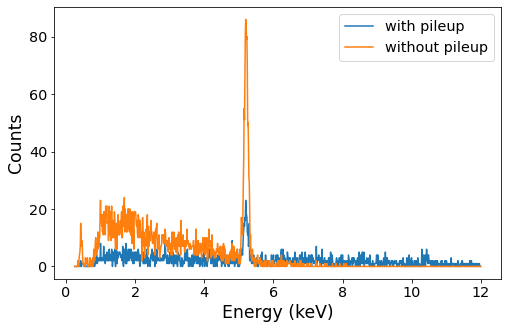

In [19]:
plt.figure(figsize=(8,5))
plt.plot(energ_lo, sim_spec, label='with pileup')
plt.plot(energ_lo, sim_nopileup, label='without pileup')
plt.xlabel('Energy (keV)', fontsize='xx-large')
plt.ylabel('Counts', fontsize='xx-large')
plt.xticks(fontsize='x-large')
plt.yticks(fontsize='x-large')
plt.legend(fontsize='x-large')
plt.show()

In [8]:
def fixbounds(p0):
    bounds = [[-10, -3], [-2, 3], [-10, 3], [0.0, 0.1]]
    eps = 0.001
    for i, [lo, hi] in enumerate(bounds):
        p0[p0[:,i] < lo, i] = lo + eps
        p0[p0[:,i] > hi, i] = hi - eps
    return p0

In [232]:
import emcee

nwalkers = 100 # number of MCMC walkers
burnin = 1000 # number of burn-in steps

ndim = len(true_pars_lpost) # number of parameters

niter = 1000 # number of iterations in production

lpost = PiledLogPosterior()

In [233]:
from multiprocessing import Pool
import os

os.environ["OMP_NUM_THREADS"] = "1"

with Pool(4) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lpost, pool=pool)
    p0 = np.random.multivariate_normal(true_pars_lpost, np.diag([1, 0.5, 0.5, 0.02]), size=nwalkers)
    p0 = fixbounds(p0)
    pos, prob, state = sampler.run_mcmc(p0, burnin, progress=True)
    sampler.reset()
    pos, prob, state = sampler.run_mcmc(pos, niter, rstate0=state, progress=True)

  0% 4/1000 [00:15<1:01:39,  3.71s/it]

impossible photons 218 [-9.80438803  1.73789725 -9.47412869  0.0898154 ] 0.03826518184935069


100% 1000/1000 [52:57<00:00,  3.18s/it]
100% 1000/1000 [52:51<00:00,  3.17s/it]


In [ ]:
### TODO: check out "impossible photons" spectrum

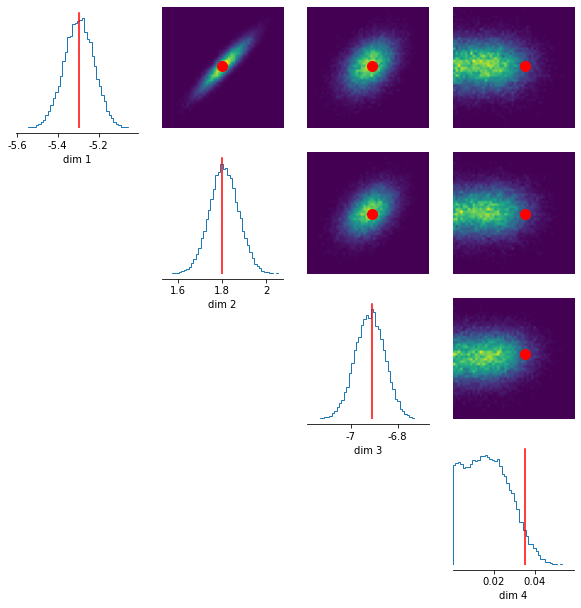

In [234]:
from sbi import analysis as analysis

_ = analysis.pairplot(sampler.flatchain, figsize=(10,10), points=np.array(true_pars_lpost)[None,:], points_colors='r')

In [235]:
np.save('emcee.npy', sampler.flatchain)

In [52]:
def simulator(p):
    return simulate_pileup_spec(p, energ_lo, energ_hi, arf, rmf, exposure=1e4)[1][7:]

In [37]:
import torch
from sbi.simulators.simutils import simulate_in_batches
from tqdm import tqdm

In [ ]:



simulator, prior = prepare_for_sbi(simulator, prior)
inference = SNPE(prior)

posteriors = []
proposal = prior

simulation_batch_size = 1
num_workers = 1

for i in tqdm(range(num_rounds)):
    if i == 0:
        theta = prior.sample((n_samples,))
    if i > 0:
        theta = proposal.sample((n_samples,), x=x_o, show_progress_bars=False)
        
    x = simulate_in_batches(
        simulator, theta, simulation_batch_size, num_workers, False
    )
    
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)

  0% 0/2 [00:00<?, ?it/s]

Neural network successfully converged after 26 epochs.


 50% 1/2 [1:54:31<1:54:31, 6871.83s/it]

Using SNPE-C with atomic loss


In [ ]:
posterior_samples = posterior.sample((10000,), x=sim_spec[7:], show_progress_bars=False)
from sbi import analysis as analysis

# plot posterior samples
_ = analysis.pairplot(posterior_samples, figsize=(10,10), points=np.array(true_pars_lpost)[None,:], points_colors='r')


In [ ]:
np.save('sequential.npy', posterior_samples.numpy())

In [ ]:
print('hi')

In [11]:
%%time
prior = utils.BoxUniform(low=[-10, -2, -10, 0], high=[-3, 3, -3, 0.1])

simulator, prior = prepare_for_sbi(simulator, prior)
inference = SNPE(prior)
### AMORTIZED
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=10000, show_progress_bar=False) # progress bar is broken
density_estimator = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior(density_estimator)  # MCMC kwargs go here.

Neural network successfully converged after 29 epochs.
CPU times: user 7h 7min 1s, sys: 4min 26s, total: 7h 11min 27s
Wall time: 1h 57min 15s


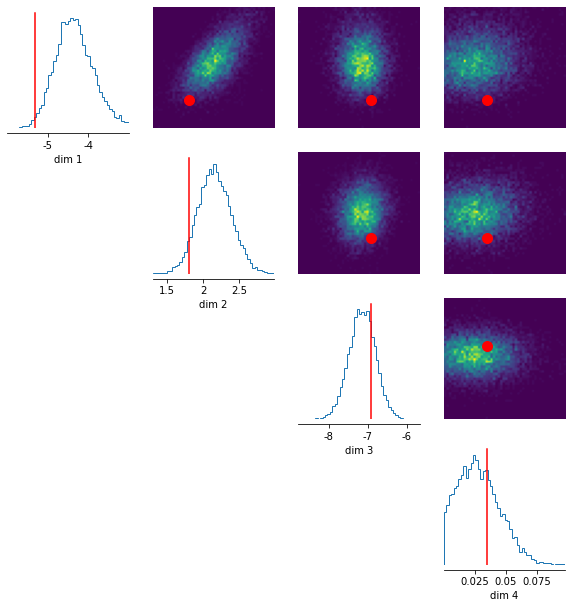

In [12]:
posterior_samples = posterior.sample((10000,), x=sim_spec[7:], show_progress_bars=False)
from sbi import analysis as analysis

# plot posterior samples
_ = analysis.pairplot(posterior_samples, figsize=(10,10), points=np.array(true_pars_lpost)[None,:], points_colors='r')

In [14]:
np.save('amortized.npy', posterior_samples.numpy())

In [50]:
from tqdm import tqdm

In [17]:
sim_spec_sbi = np.zeros((10000,sim_spec.size))
for i in tqdm(range(10000)):
    sim_spec_sbi[i,7:] = simulator(posterior_samples[i][None,:])

100% 10000/10000 [01:11<00:00, 140.35it/s]


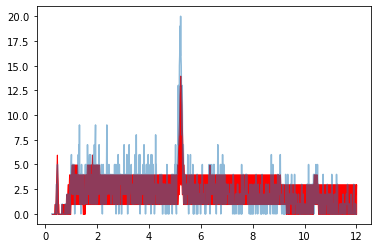

In [18]:
plt.plot(energ_lo, sim_spec, alpha=0.5)
plt.fill_between(energ_lo, np.percentile(sim_spec_sbi, 16, axis=0), np.percentile(sim_spec_sbi, 84, axis=0), fc='r', ec='r')
plt.show()

In [20]:
emcee_samples = np.load('emcee.npy')
amort_samples = np.load('amortized.npy')
seqen_samples = np.load('sequential.npy')

In [54]:
sim_spec_sbi = np.zeros((seqen_samples.shape[0], sim_spec.shape[0] - 7))

for i in tqdm(range(seqen_samples.shape[0])):
    sim_spec_sbi[i] = simulator(seqen_samples[i])

100% 10000/10000 [00:56<00:00, 177.38it/s]


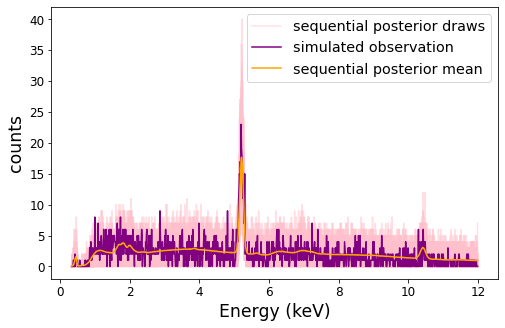

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.plot(energ_lo[7:],sim_spec_sbi[0,:].T, c="pink", alpha=0.5, label='sequential posterior draws')
ax.plot(energ_lo[7:],sim_spec_sbi[1:50,:].T, c="pink", alpha=0.5)
ax.plot(energ_lo[7:], sim_spec[7:], c='purple', label='simulated observation')
ax.plot(energ_lo[7:], np.mean(sim_spec_sbi, axis=0), c='orange', label='sequential posterior mean')
ax.set_xlabel('Energy (keV)', fontsize='xx-large')
ax.set_ylabel('counts', fontsize='xx-large')
ax.tick_params(axis='x', labelsize='large')
ax.tick_params(axis='y', labelsize='large')
ax.legend(fontsize='x-large')
#plt.savefig('pileup_spectrum.pdf')

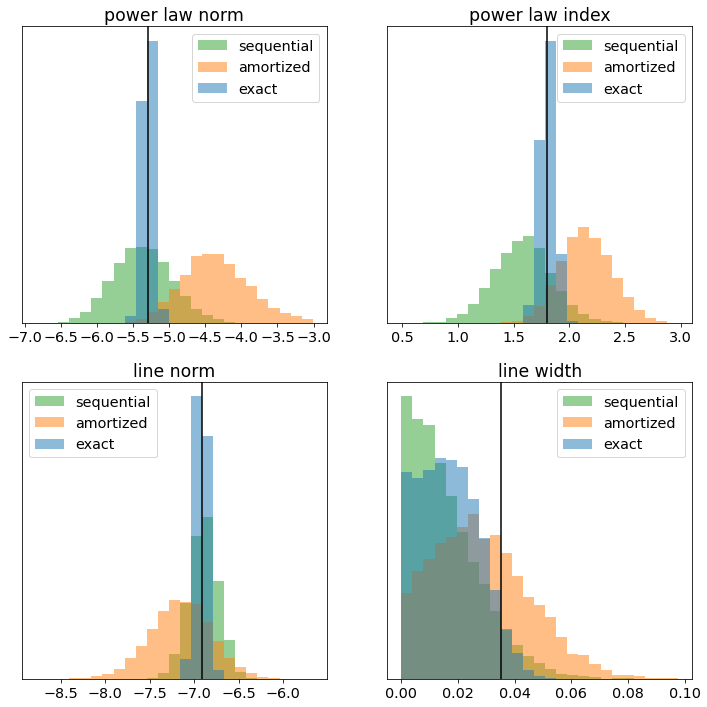

In [33]:
parameters = ['power law norm', 'power law index', 'line norm', 'line width']
plt.figure(figsize=(12, 12))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title(parameters[i], fontsize='xx-large')
    plt.hist([emcee_samples[:,i], amort_samples[:,i], seqen_samples[:,i]], label=['exact', 'amortized', 'sequential'], histtype='stepfilled', alpha=0.5, density=True, bins=25)
    plt.xticks(fontsize='x-large')
    plt.yticks([])
    plt.axvline(true_pars_lpost[i], c='k')
    plt.legend(fontsize='x-large')
plt.show()

In [25]:
emcee_samples.shape

(100000, 4)

In [26]:
amort_samples.shape

(10000, 4)

/home/idies/miniconda3/envs/ciao/lib/python3.7/site-packages/sbi/utils/plot.py:360: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],
/home/idies/miniconda3/envs/ciao/lib/python3.7/site-packages/sbi/utils/plot.py:360: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],
/home/idies/miniconda3/envs/ciao/lib/python3.7/site-packages/sbi/utils/plot.py:360: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],
/home/idies/miniconda3/envs/ciao/lib/python3.7/site-packages/sbi/utils/plot.py:360: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],
/home/idies/miniconda3/envs/ciao/lib/python3.7/site-packages/sbi/utils/plot.py:360: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],
/home/idies/miniconda3/envs/ciao/li

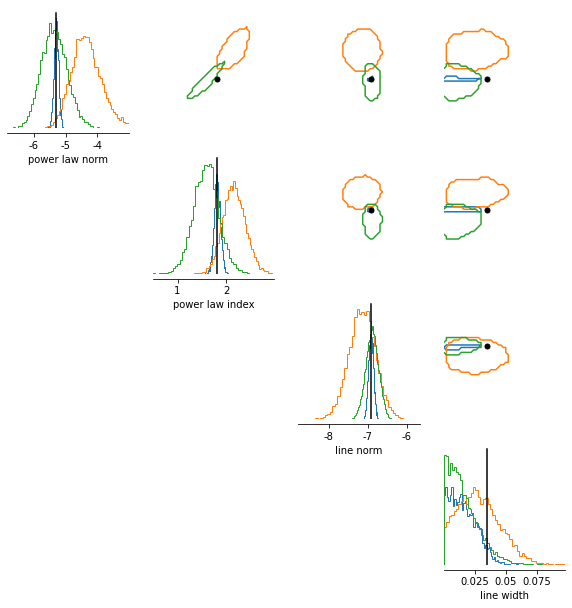

In [36]:
from sbi import analysis as analysis

# plot posterior samples
_ = analysis.pairplot([emcee_samples[::10], amort_samples, seqen_samples],
                    figsize=(10,10),
                    points=np.array(true_pars_lpost)[None,:],
                    points_colors='k',
                    upper='contour',
                    labels=parameters,
                    points_offdiag = {
                        "marker": ".",
                        "markersize": 10,
                    },
                    title_format = {"fontsize": 'xx-large'},
                    legend=True,
                    labels_samples=['exact', 'amortized', 'sequential'])

### Rejection Sampling

In [53]:
def from_prior():
    lognorm = np.random.uniform(-10, -3)
    phoindex = np.random.uniform(-2, 3)
    lognorm2 = np.random.uniform(-10, -3)
    sigma = np.random.uniform(0, 0.1)
    
    return [lognorm, phoindex, lognorm2, sigma]

In [54]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2.))

In [59]:
prior_pars_all = np.zeros((nsims, 4))

e_dist_all = []
e_dist_accept = []

pars_all = []
pars_accept = []

nsims = 500
i=0

with tqdm(total=nsims) as pbar:
    while len(e_dist_accept) < nsims:
        p = from_prior()
        prior_pars_all[i] = p

        sim_bins, sim_spec1 = simulate_pileup_spec(p, energ_lo, energ_hi, arf, rmf, exposure=1e4)
        e_dist = euclidean_distance(sim_spec1, sim_spec)

        e_dist_all.append(e_dist)
        pars_all.append(p)

        if e_dist <= 70:
            e_dist_accept.append(e_dist)
            pars_accept.append(p)
            pbar.update(1)
            i += 1
        else:
            continue

100% 500/500 [51:13<00:00,  6.15s/it]  


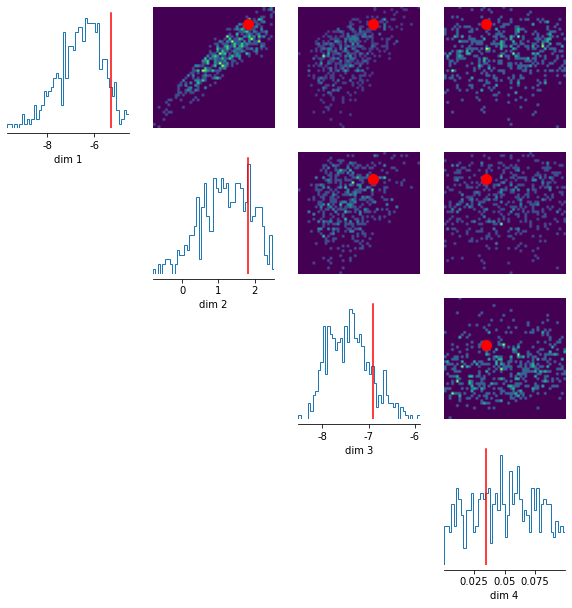

In [66]:
_ = analysis.pairplot(np.array(pars_accept), figsize=(10,10), points=np.array(true_pars_lpost)[None,:], points_colors='r')

In [67]:
500 / 0.018

27777.77777777778

In [74]:
sim_spec_rej = np.zeros((10000,sim_spec.size))
for i in tqdm(range(500)):
    sim_spec_rej[i] = simulate_pileup_spec(pars_all[i], energ_lo, energ_hi, arf, rmf, exposure=1e4)[1]

100% 500/500 [00:41<00:00, 12.15it/s]


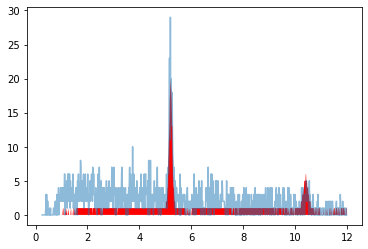

In [93]:
plt.plot(energ_lo, sim_spec, alpha=0.5)
plt.fill_between(energ_lo, np.percentile(sim_spec_rej, 1, axis=0), np.percentile(sim_spec_rej, 99, axis=0), fc='r')
plt.show()

In [113]:
density_estimator._transform._transforms[1]._transforms[0]._transforms[0].autoregressive_net.context_layer.weight.shape

torch.Size([50, 1017])

In [122]:
density_estimator._transform._transforms[1]._transforms[0]._transforms[0].autoregressive_net

MADE(
  (initial_layer): MaskedLinear(in_features=4, out_features=50, bias=True)
  (context_layer): Linear(in_features=1017, out_features=50, bias=True)
  (blocks): ModuleList(
    (0): MaskedFeedforwardBlock(
      (batch_norm): BatchNorm1d(50, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (linear): MaskedLinear(in_features=50, out_features=50, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (1): MaskedFeedforwardBlock(
      (batch_norm): BatchNorm1d(50, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (linear): MaskedLinear(in_features=50, out_features=50, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
  )
  (final_layer): MaskedLinear(in_features=50, out_features=8, bias=True)
)

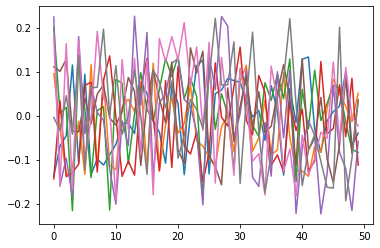

In [129]:
plt.plot(density_estimator._transform._transforms[1]._transforms[0]._transforms[0].autoregressive_net.final_layer.weight.detach().T)

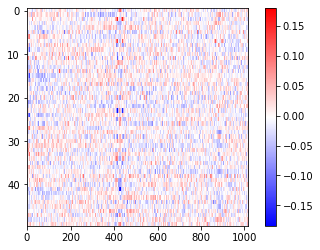

In [141]:
plt.imshow(density_estimator._transform._transforms[1]._transforms[0]._transforms[0].autoregressive_net.context_layer.weight.detach(),
           interpolation='none', aspect=20, cmap='bwr')
plt.colorbar()

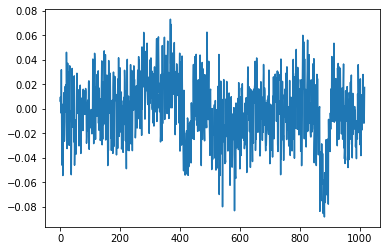

In [121]:
plt.plot(density_estimator._transform._transforms[1]._transforms[4]._transforms[0].autoregressive_net.context_layer.weight[0,:].detach())